In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import random
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.initializers import he_uniform as he
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

In [ ]:
NC = np.load('/content/drive/Shared drives/Horizon - Govind/NCwn.npy')
PD = np.load('/content/drive/Shared drives/Horizon - Govind/PDwn.npy')

data = []
dataNC = []
dataPD = []

for i in range(len(NC)):
    dataNC.append([NC[i],0])
    data.append([NC[i][15:65],0])
    #data.append([NC[i],0])

for i in range(len(PD)):
    dataPD.append([PD[i],1])
    data.append([PD[i][15:65],1])
    #data.append([PD[i],1])

data = np.array(data)    
dataNC = np.array(dataNC)
dataPD = np.array(dataPD)
np.random.seed(0)
np.random.shuffle(data)
np.random.seed(2)
np.random.shuffle(dataNC)
np.random.seed(2)
np.random.shuffle(dataPD)

print(len(data))
print(len(dataNC))
print(len(dataPD))

In [ ]:
X_train = []
X_test = []
X_train_str = []
X_test_str = []

for i in range(len(data)-len(data)//10): X_train.append(data[i,0]), X_train.append(np.flip(data[i,0], axis=2))#data augmentation  
for i in range(len(data)//10): X_test.append(data[-(i+1),0])

for i in range(len(dataNC)-19): X_train_str.append(dataNC[i,0]), X_train_str.append(np.flip(dataNC[i,0], axis=2))      
for i in range(19): X_test_str.append(dataNC[-(i+1),0])

for i in range(len(dataPD)-60): X_train_str.append(dataPD[i,0]), X_train_str.append(np.flip(dataPD[i,0], axis=2))    
for i in range(60): X_test_str.append(dataPD[-(i+1),0])

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train_str = np.array(X_train_str)
X_test_str = np.array(X_test_str)
np.random.seed(1)
np.random.shuffle(X_train_str)
np.random.seed(2)
np.random.shuffle(X_test_str)
##########################################

y_train = []
y_test = []
y_train_str = []
y_test_str = []

for i in range(len(data)-len(data)//10): y_train.append(data[i,1]), y_train.append(data[i,1])    
for i in range(len(data)//10): y_test.append(data[-(i+1),1])

for i in range(len(dataNC)-19): y_train_str.append(dataNC[i,1]), y_train_str.append(dataNC[i,1])    
for i in range(19): y_test_str.append(dataNC[-(i+1),1])

for i in range(len(dataPD)-60): y_train_str.append(dataPD[i,1]), y_train_str.append(dataPD[i,1])    
for i in range(60): y_test_str.append(dataPD[-(i+1),1])

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_str = np.array(y_train_str)
y_test_str = np.array(y_test_str)
np.random.seed(1)
np.random.shuffle(y_train_str)
np.random.seed(2)
np.random.shuffle(y_test_str)

y_train = to_categorical(y_train).astype(np.integer)
y_test = to_categorical(y_test).astype(np.integer)
y_train_str = to_categorical(y_train_str).astype(np.integer)
y_test_str = to_categorical(y_test_str).astype(np.integer)
#print(y_test)
#print(y_train)

In [ ]:
counter=0
print(len(y_test))
print(len(X_test))
print(len(y_train))
print(len(X_train))
print(np.ravel(X_test[0]))
for a in range(len(X_test)):
  for b in range(len(X_train)):
    if np.array_equal(np.ravel(X_test[a]), np.ravel(X_train[b])): print(a,b)
for a in range(len(X_test)):
  for b in range(len(data)):       
    if np.array_equal(np.ravel(X_test[a]), np.ravel(data[b,0])): counter+=1
counter

In [5]:
sample_shape = (50, 23, 39, 1)
batch_size = 32
no_epochs = 25
learning_rate = .00001
no_classes = 2
validation_split = 0.2
verbosity = 1

In [7]:
def create_model():
  model = Sequential()
  model.add(Conv3D(32, kernel_size=(3, 3, 3), padding = 'same', kernel_initializer=he(), input_shape=sample_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))
  model.add(Conv3D(64, kernel_size=(3, 3, 3), padding = 'same', kernel_initializer=he()))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))
  model.add(Conv3D(128, kernel_size=(3, 3, 3), padding = 'same', kernel_initializer=he()))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer=he()))
  model.add(Dense(256, activation='relu', kernel_initializer=he()))
  model.add(Dense(128, activation='relu', kernel_initializer=he()))
  model.add(Dense(no_classes, activation='softmax'))

  return model

In [8]:
model = create_model()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta = .001)
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=no_epochs,
                    verbose=verbosity,
                    validation_split=validation_split,
                    callbacks=[callback])

Epoch 1/25
36/36 [==============================] - 10s 86ms/step - loss: 0.4479 - accuracy: 0.7674 - val_loss: 0.2714 - val_accuracy: 0.8780
Epoch 2/25
36/36 [==============================] - 2s 66ms/step - loss: 0.1797 - accuracy: 0.9361 - val_loss: 0.1689 - val_accuracy: 0.9338
Epoch 3/25
36/36 [==============================] - 2s 65ms/step - loss: 0.1368 - accuracy: 0.9471 - val_loss: 0.1252 - val_accuracy: 0.9582
Epoch 4/25
36/36 [==============================] - 2s 64ms/step - loss: 0.1393 - accuracy: 0.9445 - val_loss: 0.1089 - val_accuracy: 0.9617
Epoch 5/25
36/36 [==============================] - 2s 65ms/step - loss: 0.0920 - accuracy: 0.9708 - val_loss: 0.1075 - val_accuracy: 0.9652
Epoch 6/25
36/36 [==============================] - 2s 66ms/step - loss: 0.1072 - accuracy: 0.9620 - val_loss: 0.0851 - val_accuracy: 0.9721
Epoch 7/25
36/36 [==============================] - 3s 71ms/step - loss: 0.0970 - accuracy: 0.9696 - val_loss: 0.0864 - val_accuracy: 0.9756
Epoch 8/25
3

In [10]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

pred = model.predict(X_test)

confus_mat = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
tn, fp, fn, tp = confus_mat.ravel()
print(confus_mat)
print(tn, fp, fn, tp)
#print(np.around(pred,2))

Test loss: 0.0481540784239769 / Test accuracy: 0.9873417615890503
[[21  1]
 [ 0 57]]
21 1 0 57


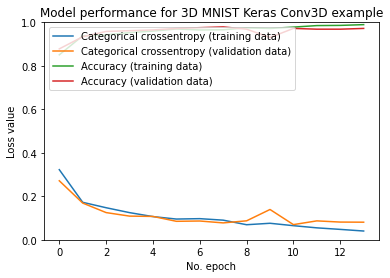

In [11]:
#for i in range(len(history.history['accuracy'])): history.history['accuracy'][i]*=100
#for i in range(len(history.history['val_accuracy'])): history.history['val_accuracy'][i]*=100
plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
X=[]
Y=[]
for i in range(len(data)): X.append(data[i,0])
for i in range(len(data)): Y.append(data[i,1])

X = np.array(X)
Y = np.array(Y)

In [ ]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
for train, test in kf.split(X, Y):
  #print(test)
  ytest=Y[test]
  counter=0
  for i in range(len(ytest)): 
    if ytest[i]==1: counter+=1
  print(counter)

In [ ]:
final_confus_mat=np.zeros(no_classes*no_classes,dtype='int64').reshape(no_classes,no_classes)

for i in range(0,1):
  kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)

  accuracies = []

  for train, test in kf.split(X, Y):
    cvX_temp = X[train]
    cvX_train = []
    for i in range(len(cvX_temp)): cvX_train.append(cvX_temp[i]), cvX_train.append(np.flip(cvX_temp[i], axis=2))
    cvX_train = np.array(cvX_train)

    cvY_temp = Y[train]
    cvY_train = []
    for i in range(len(cvY_temp)): cvY_train.append(cvY_temp[i]), cvY_train.append(cvY_temp[i])
    cvY_train = np.array(cvY_train)

    cvX_test = X[test]
    cvY_test = Y[test]
    cvY_train = to_categoconrical(cvY_train).astype(np.integer)
    cvY_test = to_categorical(cvY_test).astype(np.integer)

    temp = []
    matrices = []
    for i in range(2):
      CVmodel = create_model()
      CVmodel.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learning_rate),
                      metrics=['accuracy'])
      
      callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta = .01)
      history = CVmodel.fit([cvX_train], cvY_train,
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbosity,
                        validation_split=validation_split,
                        callbacks=[callback])
      
      score = CVmodel.evaluate([cvX_test], cvY_test, verbose=0)
      print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
      temp.append(score[1])
      pred = CVmodel.predict([cvX_test])
      matrices.append(confusion_matrix(cvY_test.argmax(axis=1), pred.argmax(axis=1)))
    print(temp)
    print(matrices)  
    accuracies.append(np.array(temp).max())
    final_confus_mat = final_confus_mat + matrices[np.argmax(np.array(temp))]

In [ ]:
print(final_confus_mat)
accuracies = np.array(accuracies)
print(accuracies.mean())
print(accuracies.std())
print(accuracies)
accuracies2 = np.array(accuracies2)
print(accuracies2.mean())
print(accuracies2.std())
accuracies2

In [ ]:
fmeans=[]
for i in range(10):
  fmeans.append(means[(((i+1)*10)-1)])
  print(means[(((i+1)*10)-1)])